# Area-to-Point Poisson Kriging

To start this tutorial, it is required to understand concepts of the Ordinary Kriging and Semivariogram Regularization. The good idea is to end Poisson Kriging - Centroid based and Poisson Kriging - Area to Area tutorials too.

The Poisson Kriging technique is used to model spatial counts over areas (blocks) of varying shapes and sizes. The counts could be number of infections, and area is a county. Following this example, we will transform the areal aggregates (rates - number of cases divided by population) of Breast Cancer in the Northeastern US counties. After transformation, we will get smooth map supported by point coordinates defined by the population grid (point support).

## Prerequisites

- **Domain**:
  - kriging
  - Poisson kriging and Poisson distribution
  - rates

- **Package**:
  - `Deconvolution()`
  - `ordinary_kriging()`
  - `TheoreticalVariogram()`
  - `centroid_poisson_kriging()`
  - `area_to_area_pk()`

- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Prepare data
2. Load regularized semivariogram model
3. Smooth blocks.
4. Export smoothed map.

## 1. Prepare data

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

from tqdm import tqdm

from pyinterpolate import TheoreticalVariogram, Blocks, PointSupport, smooth_blocks

In [2]:
DATASET = '../data/blocks/cancer_data.gpkg'
OUTPUT = '../data/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

In [3]:
blocks = Blocks(
    ds=gpd.read_file(DATASET, layer=POLYGON_LAYER),
    value_column_name=POLYGON_VALUE,
    geometry_column_name=GEOMETRY_COL,
    index_column_name=POLYGON_ID
)

In [4]:
point_support = PointSupport(
    points=gpd.read_file(DATASET, layer=POPULATION_LAYER),
    blocks=blocks,
    points_value_column=POP10,
    points_geometry_column=GEOMETRY_COL,
    verbose=True
)

<Axes: >

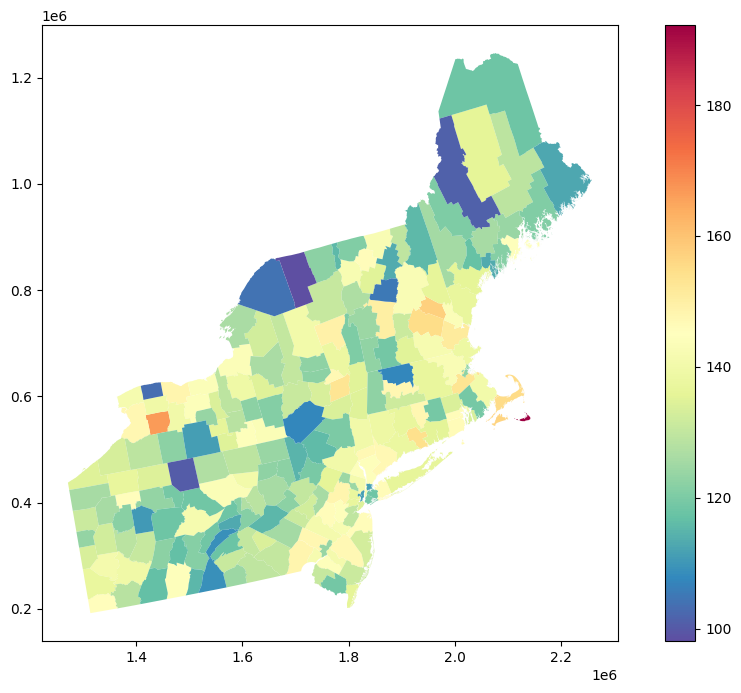

In [5]:
blocks.ds.plot(column=blocks.value_column_name,
               cmap='Spectral_r',
               legend=True,
               figsize=(12, 8))

This is our initial dataset. Cancer rates are aggregated over counties, and we have to deal with a choropleth map. In many cases, it is undesired, especially if we want to use remotely sensed data for AI/ML modeling and those aggregates. We can use Poisson Kriging to transform this representation into population blocks. But first, we need to load regularized semivariogram model.

## 2. Load regularized semivariogram model

We load a regularized semivariogram from the tutorial about Semivariogram Regularization. You can always perform semivariogram regularization along with the Poisson Kriging, but it is a very long process, and it is more convenient to separate those two steps.

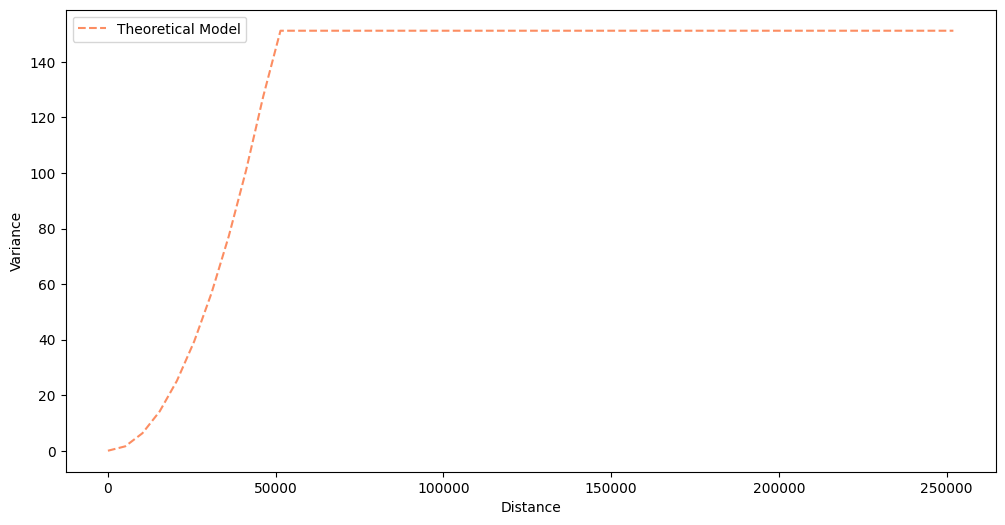

In [6]:
semivariogram = TheoreticalVariogram()
semivariogram.from_json(OUTPUT)
semivariogram.plot(experimental=False)

## 3. Smooth blocks

The process of map smoothing is straightforward. We use the `smooth_blocks()` function and pass theoretical variogram and point support objects into it. Other important parameter is `number_of_neighbors` because the final results might be affected by the number of regions that we include as the closest neighbors of a transformed area.

The method returns GeoDataFrame with points and predicted values. It iteratively re-calculates each area risk and produces predictions per point. In Area-to-Area Kriging, those predictions are aggregated. We leave them and get the smooth risk map.


In [7]:
smoothed = smooth_blocks(
    semivariogram_model=semivariogram,
    point_support=point_support,
    number_of_neighbors=16,
    data_crs=point_support.point_support.crs,
    verbose=True
)

100%|██████████| 217/217 [02:04<00:00,  1.74it/s]

Processing time: 124.61413411599915 seconds
Average RMSE (valid only for area-to-area and centroid-based Poisson Kriging: nan


In [8]:
smoothed.head()

,id,geometry,reg.est,reg.err,rmse
0,42049.0,POINT (1277277.625 441124.5),0.909623,11.744317,NaN
1,42049.0,POINT (1277277.625 431124.5),1.045285,11.475252,NaN
2,42049.0,POINT (1285937.875 446124.5),5.051654,11.820307,NaN
3,42049.0,POINT (1285937.875 436124.5),1.629313,11.122183,NaN
4,42049.0,POINT (1285937.875 426124.5),2.687778,11.970139,NaN


## 4. Export results

The last step is data visualization. We use a choropleth map from the GeoPandas, but then we will store a smoothed map as geopackage. Then, you can work on this dataset in a different program (e.g.: QGIS).

<Axes: >

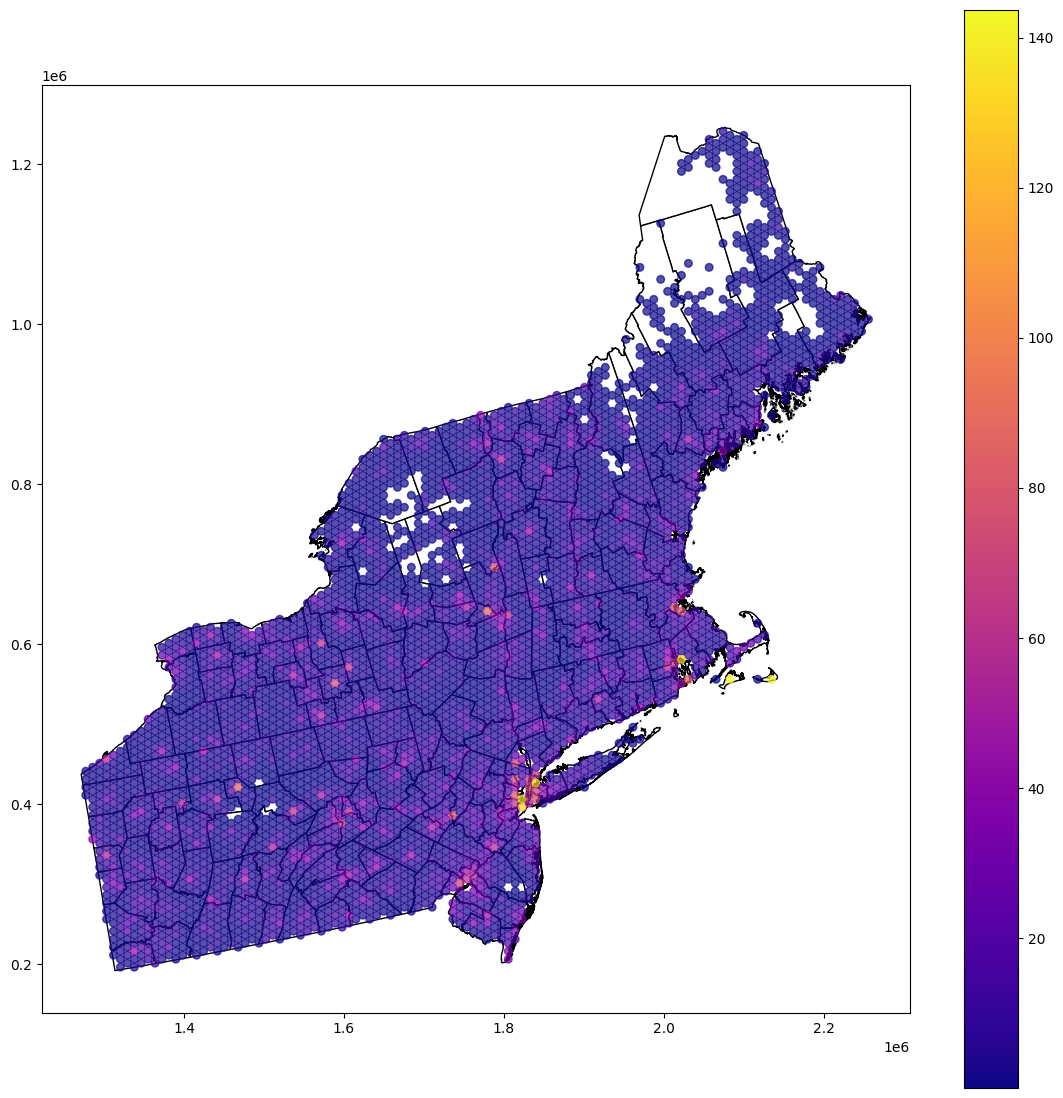

In [9]:
base = blocks.ds.plot(figsize=(14, 14), color='white', edgecolor='black')
smooth_plot_data = smoothed.copy()
smooth_plot_data[smooth_plot_data['reg.est'] < 0.01] = np.nan
smooth_plot_data.plot(ax=base, column='reg.est', cmap='plasma', legend=True, markersize=30, alpha=0.7)

<Axes: >

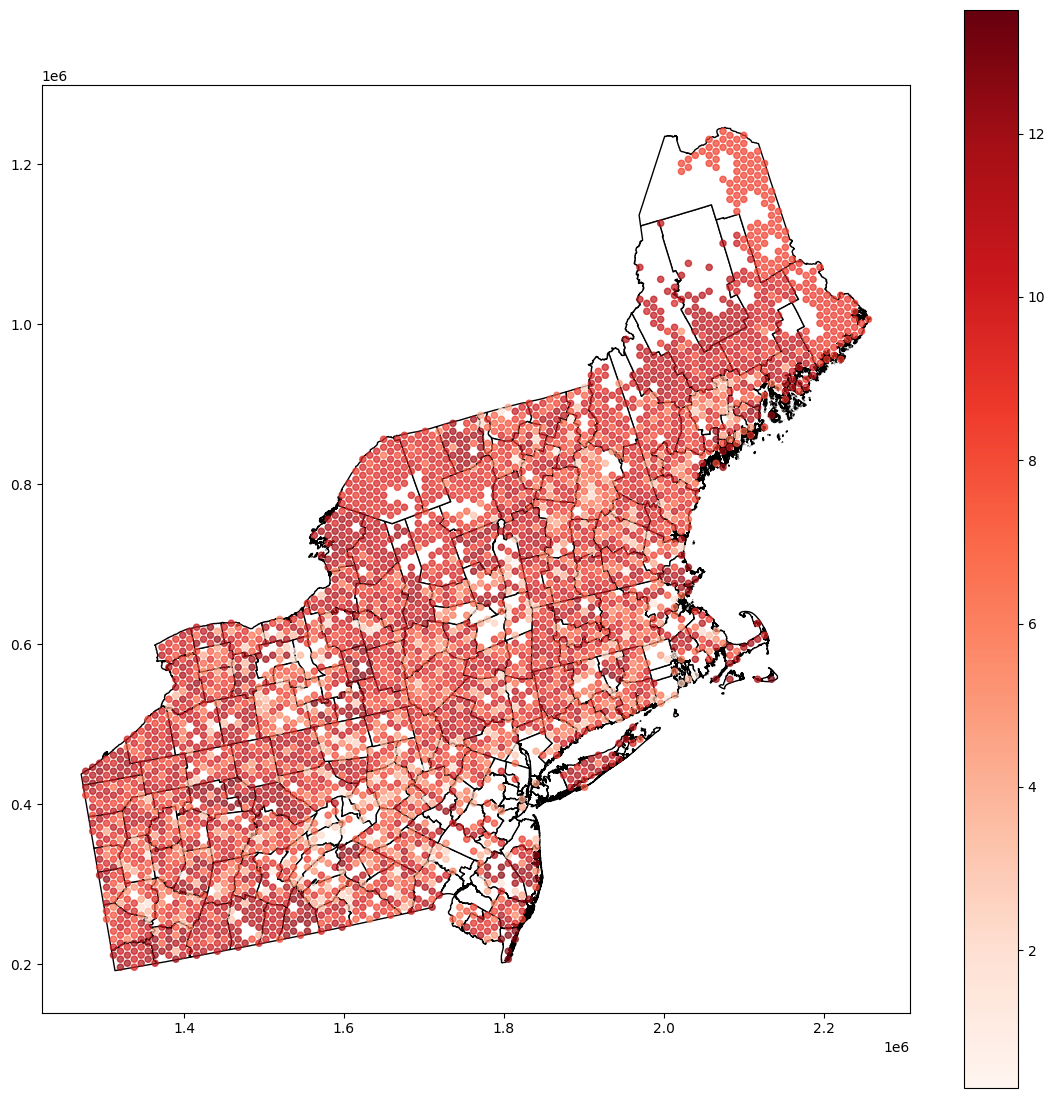

In [10]:
base = blocks.ds.plot(figsize=(14, 14), color='white', edgecolor='black')
smooth_plot_data.plot(ax=base, column='reg.err', cmap='Reds', legend=True, markersize=20, alpha=0.7)

In [11]:
# smoothed.to_file('smoothed.gpkg')

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-05-31 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |